In [187]:
from sklearn.preprocessing import OneHotEncoder
#

enc = OneHotEncoder(categories=[[2019, 2020, 2021, 2022, 2023],
                                ['m', 'n', 'r'], ], sparse=False, handle_unknown='ignore')
enc.fit_transform([[2019, 'm'],
                   [2022, 'n'],
                   [2023, 'r']])

# ans = enc.transform([[0, 2, 3]]).toarray()
# print(ans)  # 输出 [[ 1.  0.  0.  0.  1.  0.  0.  0.  1.]]

array([[1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1.]])

In [189]:
enc.get_feature_names()

array(['x0_2019', 'x0_2020', 'x0_2021', 'x0_2022', 'x0_2023', 'x1_m',
       'x1_n', 'x1_r'], dtype=object)

In [107]:
enc.categories_

[array([2019, 2020, 2021, 2022, 2023]), array([2019, 2020, 2021, 2022, 2023])]

In [1]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from time import time
from scipy import stats
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
import torch.nn as nn
import lightgbm as lgb
from utils import *
from xgboost import plot_importance


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [3]:
alldata = data[(data.asin == 'B07T1CH2HH')][['data_date',
                                             'ordered_units']].sort_values('data_date')
alldata.shape

(624, 2)

In [4]:
alldata.head(2).append(alldata.tail(2))

,data_date,ordered_units
15972,2019-12-02,865
15934,2019-12-03,259
28665,2021-08-21,146
28847,2021-08-22,187


In [5]:
pd.date_range('2019-12-2', '2021-8-22').shape

(630,)

2019-12-2到2021-8-22一共是630天的数据，所以这里少了6天的数据

In [6]:
# 缺少了多少天的数据
set(pd.date_range('2019-12-2', '2021-8-22')).difference(set(alldata.data_date))

{Timestamp('2020-06-15 00:00:00', freq='D'),
 Timestamp('2020-07-03 00:00:00', freq='D'),
 Timestamp('2021-01-27 00:00:00', freq='D'),
 Timestamp('2021-01-31 00:00:00', freq='D'),
 Timestamp('2021-02-01 00:00:00', freq='D'),
 Timestamp('2021-02-03 00:00:00', freq='D')}

In [7]:
# 每天的平均销量
alldata.mean()

ordered_units   117.0705
dtype: float64

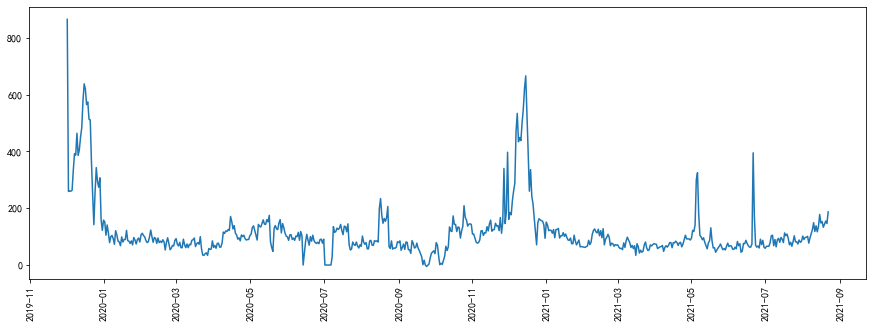

In [8]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
plt.plot(alldata.data_date, alldata.ordered_units)

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

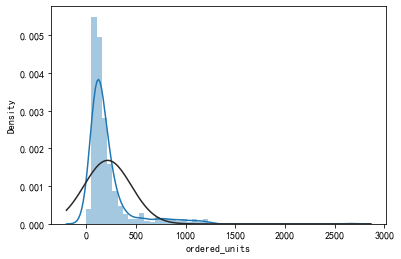

In [8]:
sns.distplot(alldata.ordered_units, fit=stats.norm)

In [7]:
alldata.ordered_units.skew(), np.log1p(alldata.ordered_units).skew()

(7.5340006644908195, -3.616558075453425)

In [8]:
from scipy.special import boxcox1p
boxcox1p(alldata.ordered_units, 0.21).skew()

0.022899662729770277

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

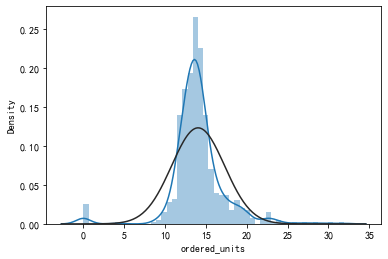

In [10]:
sns.distplot(boxcox1p(alldata.ordered_units, 0.21), fit=stats.norm)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [46]:
alldata[alldata.ordered_units <= 0].index

Int64Index([], dtype='int64')

In [10]:
alldata.drop(alldata[alldata.ordered_units <= 0].index, inplace=True)

<AxesSubplot:xlabel='ordered_units'>

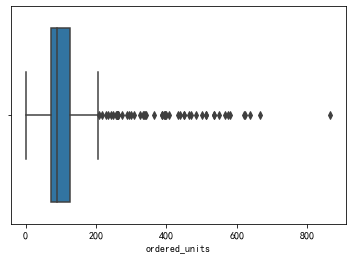

In [11]:
sns.boxplot(alldata.ordered_units)

In [12]:
alldata[alldata.ordered_units > 700].index

Int64Index([15972], dtype='int64')

In [13]:
alldata.drop(alldata[alldata.ordered_units > 700].index, inplace=True)

In [14]:
alldata.shape

(614, 2)

### 设置样本权重

In [15]:
alldata['weight'] = alldata.data_date.apply(lambda x: (
    x - pd.to_datetime('2019-12-02')).days)

In [16]:
alldata.head(1)

,data_date,ordered_units,weight
15934,2019-12-03,259,1


### 缺失值

In [47]:
alldata.isnull().sum()

data_date        0
ordered_units    0
weight           0
dtype: int64

无缺失值不用处理

### 创造特征

In [17]:
def create_feature(df):
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday  # 周几
    df['quarter'] = df.data_date.dt.quarter  # 季度
    df['weekofyear'] = df.data_date.dt.weekofyear

    df.drop('data_date', axis=1, inplace=True)
    return df

In [18]:
alldata = create_feature(alldata)

In [19]:
alldata.head(3)

,ordered_units,weight,year,month,day,weekday,quarter,weekofyear
15934,259,1,2019,12,3,1,4,49
15900,261,2,2019,12,4,2,4,49
15866,260,3,2019,12,5,3,4,49


In [24]:
columns = alldata.columns.tolist()

In [25]:
columns.remove('ordered_units')

In [47]:
alldata.columns

Index(['ordered_units', 'weight_1', 'weight_2', 'weight_3', 'weight_4',
       'weight_5', 'weight_6', 'weight_7', 'weight_8', 'weight_9',
       ...
       'weekofyear_44', 'weekofyear_45', 'weekofyear_46', 'weekofyear_47',
       'weekofyear_48', 'weekofyear_49', 'weekofyear_50', 'weekofyear_51',
       'weekofyear_52', 'weekofyear_53'],
      dtype='object', length=725)

In [28]:
alldata = pd.get_dummies(alldata, columns=columns)

In [44]:
x = alldata.drop('ordered_units', axis=1)
y = alldata['ordered_units']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=0)

In [30]:
x_train.head(2)

,weight_1,weight_2,weight_3,weight_4,weight_5,weight_6,weight_7,weight_8,weight_9,weight_10,weight_11,weight_12,weight_13,weight_14,weight_15,weight_16,weight_17,weight_18,weight_19,weight_20,weight_21,weight_22,weight_23,weight_24,weight_25,weight_26,weight_27,weight_28,weight_29,weight_30,weight_31,weight_32,weight_33,weight_34,weight_35,weight_36,weight_37,weight_38,weight_39,weight_40,weight_41,weight_42,weight_43,weight_44,weight_45,weight_46,weight_47,weight_48,weight_49,weight_50,weight_51,weight_52,weight_53,weight_54,weight_55,weight_56,weight_57,weight_58,weight_59,weight_60,weight_61,weight_62,weight_63,weight_64,weight_65,weight_66,weight_67,weight_68,weight_69,weight_70,weight_71,weight_72,weight_73,weight_74,weight_75,weight_76,weight_77,weight_78,weight_79,weight_80,weight_81,weight_82,weight_83,weight_84,weight_85,weight_86,weight_87,weight_88,weight_89,weight_90,weight_91,weight_92,weight_93,weight_94,weight_95,weight_96,weight_97,weight_98,weight_99,weight_100,weight_101,weight_102,weight_103,weight_104,weight_105,weight_106,weight_107,weight_108,weight_109,weight_110,weight_111,weight_112,weight_113,weight_114,weight_115,weight_116,weight_117,weight_118,weight_119,weight_120,weight_121,weight_122,weight_123,weight_124,weight_125,weight_126,weight_127,weight_128,weight_129,weight_130,weight_131,weight_132,weight_133,weight_134,weight_135,weight_136,weight_137,weight_138,weight_139,weight_140,weight_141,weight_142,weight_143,weight_144,weight_145,weight_146,weight_147,weight_148,weight_149,weight_150,weight_151,weight_152,weight_153,weight_154,weight_155,weight_156,weight_157,weight_158,weight_159,weight_160,weight_161,weight_162,weight_163,weight_164,weight_165,weight_166,weight_167,weight_168,weight_169,weight_170,weight_171,weight_172,weight_173,weight_174,weight_175,weight_176,weight_177,weight_178,weight_179,weight_180,weight_181,weight_182,weight_183,weight_184,weight_185,weight_186,weight_187,weight_188,weight_189,weight_190,weight_191,weight_192,weight_193,weight_194,weight_197,weight_198,weight_199,weight_200,weight_201,weight_202,weight_203,weight_204,weight_205,weight_206,weight_207,weight_208,weight_209,weight_210,weight_211,weight_212,weight_219,weight_220,weight_221,weight_222,weight_223,weight_224,weight_225,weight_226,weight_227,weight_228,weight_229,weight_230,weight_231,weight_232,weight_233,weight_234,weight_235,weight_236,weight_237,weight_238,weight_239,weight_240,weight_241,weight_242,weight_243,weight_244,weight_245,weight_246,weight_247,weight_248,weight_249,weight_250,weight_251,weight_252,weight_253,weight_254,weight_255,weight_256,weight_257,weight_258,weight_259,weight_260,weight_261,weight_262,weight_263,weight_264,weight_265,weight_266,weight_267,weight_268,weight_269,weight_270,weight_271,weight_272,weight_273,weight_274,weight_275,weight_276,weight_277,weight_278,weight_279,weight_280,weight_281,weight_282,weight_283,weight_284,weight_285,weight_286,weight_287,weight_288,weight_289,weight_290,weight_291,weight_292,weight_293,weight_294,weight_295,weight_299,weight_300,weight_301,weight_302,weight_303,weight_304,weight_305,weight_306,weight_307,weight_308,weight_309,weight_310,weight_311,weight_312,weight_313,weight_314,weight_315,weight_316,weight_317,weight_318,weight_319,weight_320,weight_321,weight_322,weight_323,weight_324,weight_325,weight_326,weight_327,weight_328,weight_329,weight_330,weight_331,weight_332,weight_333,weight_334,weight_335,weight_336,weight_337,weight_338,weight_339,weight_340,weight_341,weight_342,weight_343,weight_344,weight_345,weight_346,weight_347,weight_348,weight_349,weight_350,weight_351,weight_352,weight_353,weight_354,weight_355,weight_356,weight_357,weight_358,weight_359,weight_360,weight_361,weight_362,weight_363,weight_364,weight_365,weight_366,weight_367,weight_368,weight_369,weight_370,weight_371,weight_372,weight_373,weight_374,weight_375,weight_376,weight_377,weight_378,weight_379,weight_380,weight_381,weight_382,weight_383,weight_384,weig

In [259]:
a = pd.DataFrame({'name': ['cc', 'xx', 'mm'], 'age': [20, 20, 21]})

### 编码

In [252]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [127]:
weight_cat = list(range(1, 1000))
year_category = [2019, 2020, 2021, 2022]
month_category = list(range(1, 13))
day_category = list(range(1, 32))
weekday_cat = sorted(x_train.weekday.unique())
quarter_cat = [1, 2, 3, 4]
weekofyear_cat = sorted(x_train.weekofyear.unique())

In [129]:
encoder = OneHotEncoder(sparse=False,
                        categories=[weight_cat, year_category, month_category,
                                    day_category, weekday_cat, quarter_cat, weekofyear_cat],
                        handle_unknown='ignore')
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_train.shape, x_test.shape

((552, 1110), (62, 1110))

In [131]:
encoder.get_feature_names()

array(['x0_1', 'x0_2', 'x0_3', ..., 'x6_51', 'x6_52', 'x6_53'],
      dtype=object)

## 训练

### sklearn api

In [31]:
xgbr = XGBRegressor(n_estimators=200,
                    learning_rate=0.35,
                    max_depth=7,
                    subsample=0.6,
                    colsample_bytree=0.7,
                    objective='reg:squarederror',
                    base_score=0.5,
                    gamma=1,
                    n_jobs=8, verbosity=1)

xgbr.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
         early_stopping_rounds=20, verbose=True)

[0]	validation_0-rmse:110.87402	validation_1-rmse:80.29394
[1]	validation_0-rmse:80.88126	validation_1-rmse:55.95871
[2]	validation_0-rmse:59.91832	validation_1-rmse:48.17180
[3]	validation_0-rmse:46.95589	validation_1-rmse:48.56082
[4]	validation_0-rmse:38.96330	validation_1-rmse:51.44023
[5]	validation_0-rmse:34.70990	validation_1-rmse:54.03495
[6]	validation_0-rmse:31.94677	validation_1-rmse:55.02564
[7]	validation_0-rmse:30.46354	validation_1-rmse:54.97187
[8]	validation_0-rmse:28.45055	validation_1-rmse:55.35155
[9]	validation_0-rmse:27.63146	validation_1-rmse:55.28647
[10]	validation_0-rmse:26.43940	validation_1-rmse:57.36382
[11]	validation_0-rmse:25.29553	validation_1-rmse:57.20801
[12]	validation_0-rmse:24.30987	validation_1-rmse:56.71130
[13]	validation_0-rmse:23.90087	validation_1-rmse:58.02076
[14]	validation_0-rmse:23.24901	validation_1-rmse:58.74108
[15]	validation_0-rmse:22.69292	validation_1-rmse:58.76856
[16]	validation_0-rmse:21.51259	validation_1-rmse:58.61012
[17]	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.35, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [ ]:
# 网格搜索
# params_grid = {'learning_rate': np.arange(0, 1, 0.05)}

# params_grid = {'max_depth': range(0, 8, 1)}

# params_grid = {'subsample': np.arange(0, 1, 0.05)}
params_grid = {'colsample_bytree': np.arange(0, 1, 0.05)}

gridCV = GridSearchCV(xgbr, params_grid, cv=5, scoring='r2', n_jobs=8)

ts = time()
gridCV.fit(x_train, y_train)
print(time() - ts)
gridCV.best_params_, gridCV.best_score_

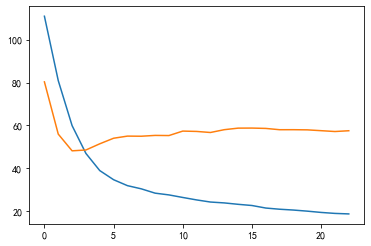

In [32]:
result = xgbr.evals_result()
plt.plot(result['validation_0']['rmse'])
plt.plot(result['validation_1']['rmse'])

### xgboost api

In [38]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'eta': 0.3,
          'objective': 'reg:squarederror',
          'gamma': 0,
          'max_depth': 5,
          'subsample': 0.5,
          'colsample_bytree': 1,
          'base_score': 0.5,
          'n_jobs': 8}

a = {}  # 记录验证集结果
model = xgb.train(params, dtrain, 300, early_stopping_rounds=20, evals=[
                  (dtest, 'test')], evals_result=a, verbose_eval=True)

[0]	test-rmse:787.05859
[1]	test-rmse:605.59271
[2]	test-rmse:535.71790
[3]	test-rmse:504.41638
[4]	test-rmse:451.57785
[5]	test-rmse:416.67691
[6]	test-rmse:368.91260
[7]	test-rmse:337.75443
[8]	test-rmse:336.24973
[9]	test-rmse:334.07410
[10]	test-rmse:320.31738
[11]	test-rmse:320.45258
[12]	test-rmse:305.20642
[13]	test-rmse:285.16476
[14]	test-rmse:286.65512
[15]	test-rmse:284.19476
[16]	test-rmse:284.05826
[17]	test-rmse:283.70371
[18]	test-rmse:279.53226
[19]	test-rmse:281.19687
[20]	test-rmse:277.47406
[21]	test-rmse:278.99527
[22]	test-rmse:273.31439
[23]	test-rmse:263.51685
[24]	test-rmse:261.43713
[25]	test-rmse:255.99350
[26]	test-rmse:256.36807
[27]	test-rmse:255.47286
[28]	test-rmse:254.09540
[29]	test-rmse:256.87180
[30]	test-rmse:258.02121
[31]	test-rmse:252.14825
[32]	test-rmse:259.23050
[33]	test-rmse:261.94702
[34]	test-rmse:259.51361
[35]	test-rmse:260.83997
[36]	test-rmse:257.71121
[37]	test-rmse:259.52267
[38]	test-rmse:266.07889
[39]	test-rmse:259.49432
[40]	test-

## 测试

### sklearn api

In [33]:
y_pred = xgbr.predict(x_test)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.793
metrics2: 0.734
r2: 0.451


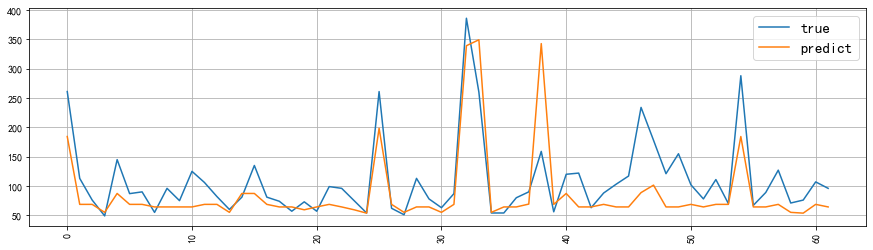

In [34]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend(fontsize=15)

In [43]:
a = xgbr.get_booster().get_score(importance_type='gain')
# len(a)
dict(sorted(a.items(), key=lambda x: x[1], reverse=True))

{'year_2019': 272731.80800599995,
 'month_12': 199261.08871,
 'month_10': 85429.375,
 'quarter_4': 81458.08985,
 'weekofyear_52': 68594.007825,
 'weekofyear_51': 59514.36466125001,
 'weekofyear_50': 46442.63745,
 'weight_22': 44481.0,
 'weekofyear_49': 42007.82625333333,
 'month_11': 35032.21924,
 'weekofyear_18': 23481.375,
 'weight_29': 22276.701512000003,
 'weekofyear_53': 21718.21765633333,
 'weight_383': 20263.37434,
 'weight_366': 13232.1719,
 'weekday_6': 11713.964697200001,
 'month_3': 10952.277345,
 'month_9': 10939.460856666667,
 'day_30': 10765.9922,
 'weekofyear_40': 10700.410155,
 'weight_567': 10497.114602999998,
 'weight_364': 10161.621789999997,
 'weight_384': 9367.9092576,
 'weekofyear_41': 7883.5817875,
 'weight_361': 7477.039685714285,
 'weight_367': 7083.093775,
 'weight_521': 6458.8933099999995,
 'weight_20': 6086.1967724999995,
 'weight_14': 6016.07764,
 'weekofyear_34': 5982.394774,
 'weekofyear_13': 5540.1875,
 'day_6': 5491.43799,
 'weekofyear_48': 5490.1191450

In [36]:
xgbr.ge

array([0.00142752, 0.        , 0.00181159, 0.00248468, 0.        ,
       0.00164965, 0.00168922, 0.        , 0.        , 0.0025701 ,
       0.00115512, 0.00117059, 0.00125531, 0.00420629, 0.        ,
       0.00038126, 0.00010831, 0.00132777, 0.00103866, 0.00425532,
       0.        , 0.03110002, 0.00152523, 0.00110789, 0.        ,
       0.        , 0.        , 0.        , 0.01557532, 0.        ,
       0.        , 0.00028001, 0.        , 0.00017888, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00002802,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00060197, 0.00026488, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [212]:
x_train.shape

(552, 1110)

In [215]:
encoder.get_feature_names().shape

(1110,)

In [226]:
['f'+str(i) for i in list(range(1100))][999:-1]

['f999',
 'f1000',
 'f1001',
 'f1002',
 'f1003',
 'f1004',
 'f1005',
 'f1006',
 'f1007',
 'f1008',
 'f1009',
 'f1010',
 'f1011',
 'f1012',
 'f1013',
 'f1014',
 'f1015',
 'f1016',
 'f1017',
 'f1018',
 'f1019',
 'f1020',
 'f1021',
 'f1022',
 'f1023',
 'f1024',
 'f1025',
 'f1026',
 'f1027',
 'f1028',
 'f1029',
 'f1030',
 'f1031',
 'f1032',
 'f1033',
 'f1034',
 'f1035',
 'f1036',
 'f1037',
 'f1038',
 'f1039',
 'f1040',
 'f1041',
 'f1042',
 'f1043',
 'f1044',
 'f1045',
 'f1046',
 'f1047',
 'f1048',
 'f1049',
 'f1050',
 'f1051',
 'f1052',
 'f1053',
 'f1054',
 'f1055',
 'f1056',
 'f1057',
 'f1058',
 'f1059',
 'f1060',
 'f1061',
 'f1062',
 'f1063',
 'f1064',
 'f1065',
 'f1066',
 'f1067',
 'f1068',
 'f1069',
 'f1070',
 'f1071',
 'f1072',
 'f1073',
 'f1074',
 'f1075',
 'f1076',
 'f1077',
 'f1078',
 'f1079',
 'f1080',
 'f1081',
 'f1082',
 'f1083',
 'f1084',
 'f1085',
 'f1086',
 'f1087',
 'f1088',
 'f1089',
 'f1090',
 'f1091',
 'f1092',
 'f1093',
 'f1094',
 'f1095',
 'f1096',
 'f1097',
 'f1098']

In [247]:
zipp = zip(['f'+str(i) for i in list(range(1200))],
           encoder.get_feature_names())

In [248]:
cc = dict(list(zipp))

In [249]:
for i in zipp:
    print(i)

In [250]:
cc['f110']

'x0_111'

In [227]:
bb

[('f1000', 30),
 ('f1049', 14),
 ('f1107', 13),
 ('f566', 12),
 ('f1052', 11),
 ('f363', 10),
 ('f1048', 10),
 ('f1050', 10),
 ('f1106', 9),
 ('f519', 9),
 ('f360', 9),
 ('f1047', 9),
 ('f520', 9),
 ('f1007', 9),
 ('f1090', 8),
 ('f999', 8),
 ('f1014', 7),
 ('f1038', 7),
 ('f381', 7),
 ('f1057', 7),
 ('f1051', 7),
 ('f1031', 7),
 ('f23', 7),
 ('f1105', 6),
 ('f1005', 6),
 ('f1097', 6),
 ('f1081', 6),
 ('f1011', 6),
 ('f388', 6),
 ('f1025', 6),
 ('f1023', 6),
 ('f1030', 6),
 ('f1104', 6),
 ('f1029', 6),
 ('f1053', 6),
 ('f19', 6),
 ('f1001', 6),
 ('f1100', 6),
 ('f366', 6),
 ('f377', 6),
 ('f383', 5),
 ('f1056', 5),
 ('f1095', 5),
 ('f1022', 5),
 ('f1036', 5),
 ('f378', 5),
 ('f27', 5),
 ('f382', 5),
 ('f1039', 5),
 ('f380', 5),
 ('f1054', 5),
 ('f395', 5),
 ('f1040', 5),
 ('f1003', 5),
 ('f231', 5),
 ('f1108', 4),
 ('f256', 4),
 ('f1020', 4),
 ('f1008', 4),
 ('f1055', 4),
 ('f43', 4),
 ('f327', 4),
 ('f371', 4),
 ('f1028', 4),
 ('f1024', 4),
 ('f1013', 4),
 ('f1062', 4),
 ('f5', 4),
 (

In [251]:
list(map(lambda x: cc[x[0]], bb))

['x1_2020',
 'x4_3',
 'x6_51',
 'x0_567',
 'x4_6',
 'x0_364',
 'x4_2',
 'x4_4',
 'x6_50',
 'x0_520',
 'x0_361',
 'x4_1',
 'x0_521',
 'x2_5',
 'x6_34',
 'x1_2019',
 'x2_12',
 'x3_24',
 'x0_382',
 'x6_1',
 'x4_5',
 'x3_17',
 'x0_24',
 'x6_49',
 'x2_3',
 'x6_41',
 'x6_25',
 'x2_9',
 'x0_389',
 'x3_11',
 'x3_9',
 'x3_16',
 'x6_48',
 'x3_15',
 'x5_1',
 'x0_20',
 'x1_2021',
 'x6_44',
 'x0_367',
 'x0_378',
 'x0_384',
 'x5_4',
 'x6_39',
 'x3_8',
 'x3_22',
 'x0_379',
 'x0_28',
 'x0_383',
 'x3_25',
 'x0_381',
 'x5_2',
 'x0_396',
 'x3_26',
 'x2_1',
 'x0_232',
 'x6_52',
 'x0_257',
 'x3_6',
 'x2_6',
 'x5_3',
 'x0_44',
 'x0_328',
 'x0_372',
 'x3_14',
 'x3_10',
 'x2_11',
 'x6_6',
 'x0_6',
 'x3_23',
 'x2_8',
 'x6_43',
 'x6_40',
 'x6_33',
 'x6_13',
 'x3_19',
 'x0_573',
 'x6_14',
 'x0_313',
 'x3_21',
 'x6_11',
 'x6_38',
 'x3_1',
 'x0_395',
 'x6_18',
 'x0_197',
 'x0_7',
 'x4_0',
 'x3_2',
 'x3_20',
 'x0_18',
 'x0_19',
 'x0_500',
 'x0_380',
 'x0_258',
 'x3_5',
 'x6_21',
 'x3_3',
 'x0_629',
 'x6_28',
 'x0_3

In [222]:
bb = sorted(a.items(), key=lambda x: x[1], reverse=True)

In [204]:
import xgboost

In [209]:
'{1}\t{0}\tq\n'.format(1, 2)

'2\t1\tq\n'

<AxesSubplot:>

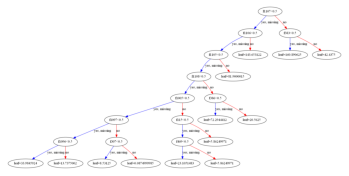

In [206]:
xgboost.plot_tree(xgbr)

In [203]:
encoder.get_feature_names().shape

(1110,)

In [ ]:
pd.concat()

### xgboost api

In [35]:
dtest = xgb.DMatrix(x_test, y_test)

In [36]:
y_pred = model.predict(dtest)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.939
metrics2: 0.732
r2: 0.858


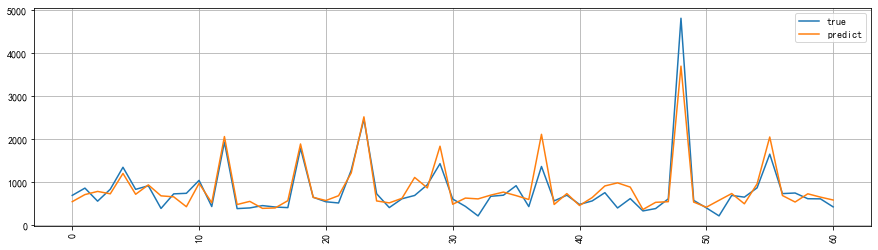

In [37]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

In [ ]:
model.get_score(importance_type='gain')

In [ ]:
xgb.to_graphviz(model, num_trees=0)

In [ ]:
import xgboost
from xgboost import XGBClassifier
from sklearn.datasets import load_iris

iris = load_iris()
x, y = iris.data, iris.target
model = XGBClassifier()
model.fit(x, y)
# 如果输入是没有表头的array,会自动以f1,f2开始,需要更换表头
# 画树结构图的时候也需要替换表头

model.get_booster().feature_names = iris.feature_names
# max_num_features指定排名最靠前的多少特征
# height=0.2指定柱状图每个柱子的粗细,默认是0.2
# importance_type='weight'默认是用特征子树中的出现次数(被选择次数),还有"gain"和"cover"
xgboost.plot_importance(model, max_num_features=5, importance_type='gain')

# f_score就是feature score
model.feature_importances_  # 这里的特征重要性就是gain进行归一化之后的值

In [ ]:
model.feature_importances_.sum()

In [ ]:
2.9918/(2.9918+1.3149+0.0727+0.0424)

In [ ]:
xgb.to_graphviz(model, num_trees=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(max_depth=2)

In [ ]:
dt.fit(x, y)

In [ ]:
import graphviz
from sklearn import tree
import pydotplus
from IPython.display import Image

In [ ]:
# 对于决策树来说，特征重要性就等于这个特征分裂的时候的总信息增益，这个特征有可能分裂，加到一起就行
dt.feature_importances_

In [ ]:
dot = tree.export_graphviz(dt)
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())